# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env allows the learner to hold a position as a percentage



In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, csv, math
import numpy as np
import pandas as pd
import gymnasium as gym
import statsmodels.api as sm

from gymnasium import spaces
from datetime import date
from envs.env_gridsearch import kellycriterion
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df
from utils.rlmetrics import get_return, get_metrics

# Find parameters in `params.py`
from params import *
from envs.env_rl_freeop import PairTradingEnv

from stable_baselines3 import PPO, A2C, DQN
import quantstats as qs

folder_path = f"result/rl-freeop-zscore/"
os.makedirs(folder_path, exist_ok=True)

Load data from `preliminaries.ipynb`

In [2]:
import pickle

with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

df0 = dfs[0][dfs[0]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']==data[0][1]].reset_index(drop=True)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [3]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

print(f"The length of our training data: {len(train0)}")

The length of our training data: 1191842


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [4]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1, noThres=True)
check_env(env)

## Do an experimental run with random generated actions

In [5]:
env = PairTradingEnv(train0, train1, tc=0, noThres=True, verbose=1, model=f"{folder_path}/networth_experiment.csv")
obs, _ = env.reset()

print(f"observation_space: {env.observation_space}")
print(f"action_space: {env.action_space}")
print(f"action_space.sample: {env.action_space.sample()}")

n_steps = 20

for step in range(n_steps):
    obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
    done = terminated or truncated
    env.render()
    if done:
        break

observation_space: Dict('position': Box(-1.0, 1.0, (1,), float64), 'zscore': Box(-inf, inf, (1,), float64))
action_space: Discrete(3)
action_space.sample: 1
networth 10969.448442730118, action 0, kc 1, pos -1.0, holding0 -0.035514276916891976, holding1 0.0010850164651248582
networth 9999.82613757729, action 2, kc 1, pos -0.0010061194650555745, holding0 -3.5695691163760424e-05, holding1 8.963316046224634e-07
networth 9999.824392622128, action 1, kc 1, pos -0.0010067744809884294, holding0 -3.5695691163760424e-05, holding1 8.963316046224634e-07
networth 9029.603024386448, action 0, kc 1, pos 1.0, holding0 0.03546964649531517, holding1 -0.001084613991303565
networth 9999.41808059812, action 0, kc 1, pos 0.00040612745237133147, holding0 1.4399349196649036e-05, holding1 0.0
networth 10968.869507580857, action 0, kc 1, pos -1.0, holding0 -0.03549083660794995, holding1 0.001084613991303565
networth 9999.07138220044, action 2, kc 1, pos 4.851783793870734e-05, holding0 1.7220222076480551e-06, ho

## Models from stable_baselines3

Train with training data

In [6]:
'''PPO'''

env = PairTradingEnv(train0, train1, tc=0, noThres=True, model=f"{folder_path}/networth_ppo.csv")

model_ppo = PPO("MultiInputPolicy", env, verbose=0, tensorboard_log="logs")
model_ppo.learn(total_timesteps=20000)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [7]:
'''A2C'''

env = PairTradingEnv(train0, train1, tc=0, noThres=True, model=f"{folder_path}/networth_a2c.csv")

model_a2c = A2C("MultiInputPolicy", env, verbose=0)
model_a2c.learn(total_timesteps=20000)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [8]:
'''DQN'''

env = PairTradingEnv(train0, train1, tc=0, noThres=True, model=f"{folder_path}/networth_dqn.csv")

model_dqn = DQN("MultiInputPolicy", env, verbose=0)
model_dqn.learn(total_timesteps=20000)
model_dqn.save(f"{folder_path}/dqn_pairtrading")

## Use the model on Test data

In [9]:
# del model_ppo, model_a2c, model_dqn

model_ppo = PPO.load(f"{folder_path}/ppo_pairtrading.zip")
model_a2c = A2C.load(f"{folder_path}/a2c_pairtrading.zip")
model_dqn = DQN.load(f"{folder_path}/dqn_pairtrading.zip")

In [10]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
    print("existing networth_ppo.csv removed")
except OSError:
    print("currently no ppo results")

env = PairTradingEnv(test0, test1, tc=0, noThres=True, model=f"{folder_path}/networth_ppo.csv")
obs, _ = env.reset()

while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

currently no ppo results
Test Finished!


In [11]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
    print("existing networth_a2c.csv removed")
except OSError:
    print("currently no a2c results")

env = PairTradingEnv(test0, test1, tc=0, noThres=True, model=f"{folder_path}/networth_a2c.csv")
obs, _ = env.reset()

while True:
    action, _states = model_a2c.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

currently no a2c results
Test Finished!


In [12]:
try:
    os.remove(f"{folder_path}/networth_dqn.csv")
    print("existing networth_dqn.csv removed")
except OSError:
    print("currently no dqn results")

env = PairTradingEnv(test0, test1, tc=0, noThres=True, model=f"{folder_path}/networth_dqn.csv")
obs, _ = env.reset()

while True:
    action, _states = model_dqn.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

currently no dqn results
Test Finished!


### Analyze with Quanstats

In [13]:

os.remove(f"{folder_path}networth_experiment.csv") if os.path.exists(f"{folder_path}networth_experiment.csv") else None
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_a2c.csv is ['2023-10-31 23:59:59.999000', '9984.319824060285']
The ending capital of networth_dqn.csv is ['2023-10-31 23:59:59.999000', '10818.897641141952']
The ending capital of networth_ppo.csv is ['2023-10-31 23:59:59.999000', '9261.011332765038']
The best model is networth_dqn.csv


In [14]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

Total orders count: 242738
Total long action: 157004
Total short action: 85473
Won orders count: 157004
Lost orders count: 85473
Win/Loss order ratio: 1.8368841622500673
Avg order pnl: 0.008776850951951519
Avg order pnl won: 0.10189789079607947
Avg order pnl lost: -0.16224891135414524
Avg long order pnl: -0.060779547895762294
Avg short order pnl: 0.010175553826745029


                    Strategy
------------------  ----------
Start Period        2023-05-16
End Period          2023-10-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   -1.43%
CAGR﹪              -2.14%

Sharpe              0.83
Prob. Sharpe Ratio  75.3%
Sortino             1.28
Sortino/√2          0.91
Omega               1.15

Max Drawdown        -20.47%
Longest DD Days     121

Gain/Pain Ratio     0.15
Gain/Pain (1M)      10.08

Payoff Ratio        1.06
Profit Factor       1.15
Common Sense Ratio  1.4
CPC Index           0.63
Tail Ratio          1.22
Outlier Win Ratio   2.59
Outlier Loss Ratio  2.25

MTD                 21.01%
3M                  8.35%
6M                  -1.43%
YTD                 -1.43%
1Y                  -1.43%
3Y (ann.)           -2.14%
5Y (ann.)           -2.14%
10Y (ann.)          -2.14%
All-time (ann.)     -2.14%

Avg. Drawdown       -16.83%
Avg. Drawdown Days  26
Recovery Factor     4.69
Ulcer Index         0.13
Serenity Index      

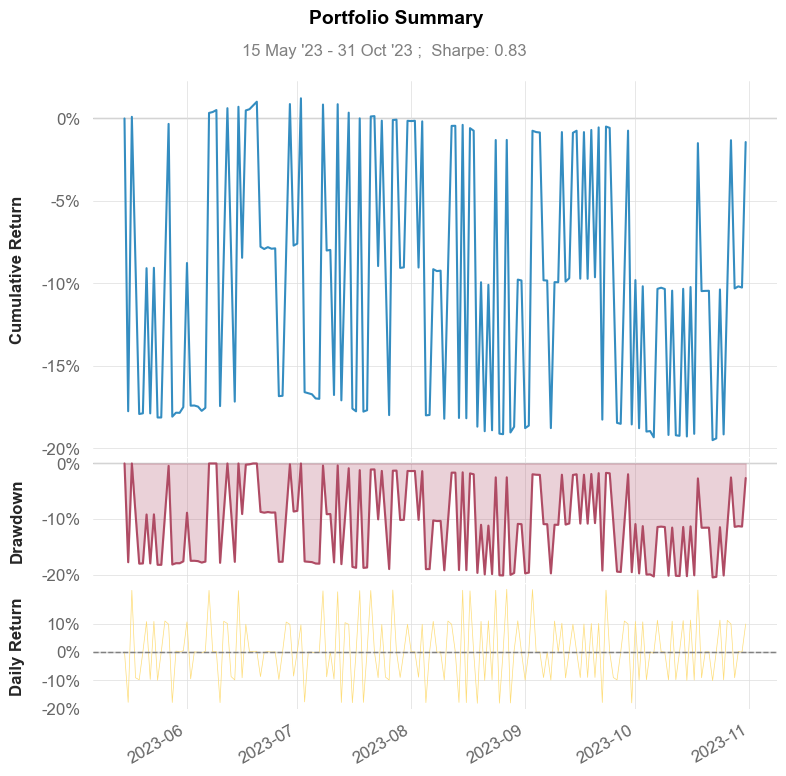

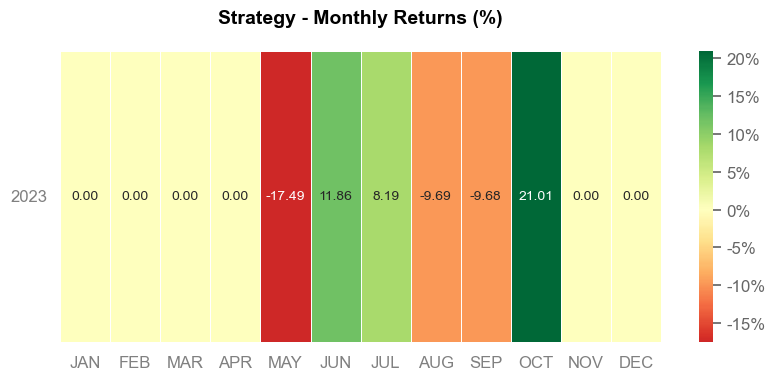

In [15]:
best_return_daily = best_return['returns'].resample('1d').apply(lambda x: np.prod(1 + x) - 1)
qs.reports.basic(best_return_daily)

In [16]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates

# fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# ax1.plot(best_return.index, best_return['returns'], linewidth=0.5)
# ax1.set_title("Portfolio Returns")

# ax2.plot(best_return.index, best_return['values'], linewidth=0.5)
# ax2.set_title("Portfolio Networth")

# ax2.set_xticklabels(ax2.get_xticks(), rotation=45)
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))